# 数据读入模块

In [269]:
import pandas as pd

train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [270]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


## 处理NAN

In [271]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [272]:
df_train = delnan(train_data)
df_test = delnan(test_data)


In [273]:
""" for i in range(2, 17):
    print(df_train.iloc[:, i].value_counts()) """


' for i in range(2, 17):\n    print(df_train.iloc[:, i].value_counts()) '

In [274]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14"]

## 转化为one-hot编码（不宜采用）

In [275]:
""" 
def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col) 
for i in x_col:
    if i not in df_test.columns:
        df_test[i] = 0
"""

' \ndef to_one_hot(df, colnames):\n    df = pd.get_dummies(df, columns=colnames)\n    return df\n\n\ndf_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col) \nfor i in x_col:\n    if i not in df_test.columns:\n        df_test[i] = 0\n'

## 证据权重

In [276]:
import pandas as pd
import numpy as np

def cal_woe(df,df_no_label,x_cols,y_col):
    for i in x_cols:
        x_set=pd.unique(df[i])
        for j in x_set:
            woe=np.mean(df[df[i]==j][y_col])
            df[i].replace(j,woe,inplace=True)
            df_no_label[i].replace(j,woe,inplace=True)
    return df,df_no_label

In [277]:
df_train,df_test=cal_woe(df_train,df_test,type_col,"label")

In [278]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]

x_col = basic_col+loan_col+overdue_col+query_col
# x_col为模型读入的自变量列名称


x_col=['loan2_3_y',
 'loan1_6',
 'loan1_32',
 'loan1_31',
 'basic_7',
 'loan2_4_y',
 'loan2_3',
 'loan1_15',
 'loan2_5_y',
 'loan1_30',
 'loan1_7',
 'loan1_3',
 'query_1',
 'query_7',
 'loan1_17',
 'query_4',
 'loan1_14',
 'basic_1_y',
 'loan1_21',
 'query_1_y']

In [279]:
# df_train.drop(columns=drop_col)

# 训练模型

## 划分测试集训练集

In [280]:
""" from sklearn import model_selection


X = df_train[x_col]
Y = df_train["label"]
seed = 666
test_size = 0.1
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=test_size, random_state=seed) """


' from sklearn import model_selection\n\n\nX = df_train[x_col]\nY = df_train["label"]\nseed = 666\ntest_size = 0.1\nX_train, X_test, y_train, y_test = model_selection.train_test_split(\n    X, Y, test_size=test_size, random_state=seed) '

## 训练模型

## 超参数

In [281]:
N = 200
num_round = 100

max_depth = [3, 4, 5,7]
eta = [0.1,0.05,0.2]
colsample_bytree = [0.75, 0.7, 0.65]
scale_pos_weight = [1, 3, 6, 10, 30]
test_size=[0.1,0.2,0.3,0.5]


In [282]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
test_labels = []
loss_seq = []
max_auc_loss = 0
flag=0

for i in range(N):

    X = df_train[x_col]
    Y = df_train["label"]

    #seed = 666
    test_size_this_round=random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    x_perd = xgb.DMatrix(df_test[x_col])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtrain, 'train'), (dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        # 'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0
    }
    
    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=10, verbose_eval=False)
    loss = float(bst.eval(dtest).split(":")[1])
    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])

    loss_seq.append(loss)

    temp_dict={"auc":loss,'test_size':test_size_this_round}
    temp_dict.update(param)

    #info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag==0:
        info_df=pd.DataFrame(temp_dict,index=[i])
        flag=1
    else:
        info_df=pd.concat([info_df,pd.DataFrame(temp_dict,index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss
    

    print(i+1, ":", loss, sep="")
    #print(param)
    #print("-------------------------")
    pred_labels.append([j for j in pred_label])
    test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(loss_seq), sep="")


1:0.7041928059690412
2:0.7054283777441727
3:0.7267166844606266
4:0.7388368041929124
5:0.6925546055298409
6:0.7720185821560392
7:0.7353481839006778
8:0.7284848579750086
9:0.7089864807335836
10:0.7567051707897476
最大AUC:0.7720185821560392


In [287]:
info_df

,auc,test_size,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,seed,tree_method,gpu_id
0,0.704193,0.1,5,0.20,0.65,binary:logistic,3,auc,666,gpu_hist,0
1,0.705428,0.2,5,0.20,0.70,binary:logistic,6,auc,666,gpu_hist,0
2,0.726717,0.3,3,0.10,0.70,binary:logistic,6,auc,666,gpu_hist,0
3,0.738837,0.3,4,0.05,0.70,binary:logistic,6,auc,666,gpu_hist,0
4,0.692555,0.1,3,0.10,0.70,binary:logistic,30,auc,666,gpu_hist,0
5,0.772019,0.1,5,0.05,0.65,binary:logistic,6,auc,666,gpu_hist,0
6,0.735348,0.1,4,0.10,0.70,binary:logistic,1,auc,666,gpu_hist,0
7,0.728485,0.1,7,0.10,0.70,binary:logistic,6,auc,666,gpu_hist,0
8,0.708986,0.3,3,0.05,0.75,binary:logistic,30,auc,666,gpu_hist,0
9,0.756705,0.1,5,0.10,0.70,binary:logistic,10,auc,666,gpu_hist,0


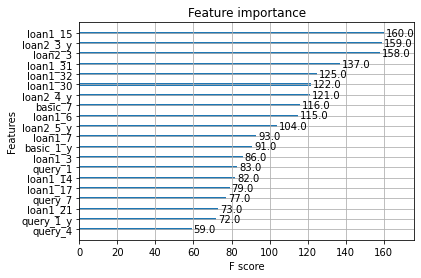

In [284]:
pic=xgb.plot_importance(best_bst,max_num_features=20)
temp=pic.get_ymajorticklabels()
important_x=[str(i).split("\'")[1] for i in temp]
important_x.reverse()

In [285]:
important_x

['loan1_15',
 'loan2_3_y',
 'loan2_3',
 'loan1_31',
 'loan1_32',
 'loan1_30',
 'loan2_4_y',
 'basic_7',
 'loan1_6',
 'loan2_5_y',
 'loan1_7',
 'basic_1_y',
 'loan1_3',
 'query_1',
 'loan1_14',
 'loan1_17',
 'query_7',
 'loan1_21',
 'query_1_y',
 'query_4']

# 输出模块

In [286]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in loss_seq])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if False:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(test_labels[res_num[i]])
        temp = np.mean(list_temp, axis=0)
        temp_auc = roc_auc_score(y_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i
else:
    n = 100

res_num = res_num[0:n]

final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [loss_seq[i] for i in res_num], sep="")
# print("平均之后最大AUC为",max_auc,sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


本地测试集前100个auc为[0.7720185821560392, 0.7567051707897476, 0.7388368041929124, 0.7353481839006778, 0.7284848579750086, 0.7267166844606266, 0.7089864807335836, 0.7054283777441727, 0.7041928059690412, 0.6925546055298409]


# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？